# IML - data exploration

Daps dataset contains recordings of 20 people (10 woman, 10 men) reading 5 scripts in different 
environments.

In [7]:
import librosa
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.fft import fft, ifft, fftfreq

DATA_PATH = os.path.join(os.getcwd(), "..", "data")
DAPS_PATH = os.path.join(DATA_PATH, "daps")

In [2]:
filepath = os.path.join(DAPS_PATH, "sample", "m2_script1_ipad_bedroom1.wav")

# Set sr to None to use native sample rate
y, sr = librosa.load(filepath, sr=5012)

print("Shape of y:", y.shape)
print("Sample rate:", sr)

Shape of y: (827856,)
Sample rate: 5012


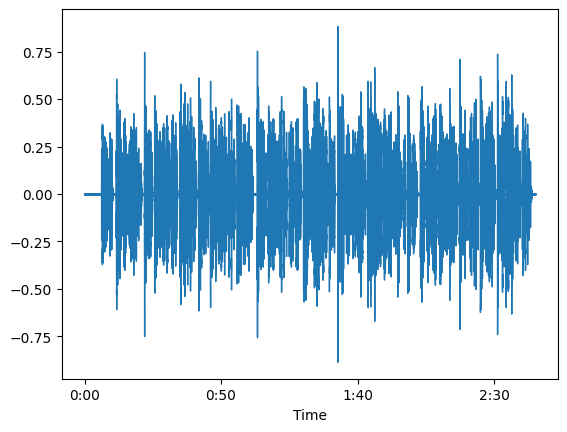

In [12]:
# plot of signal frequencies
librosa.display.waveshow(y, sr=sr)
plt.show()

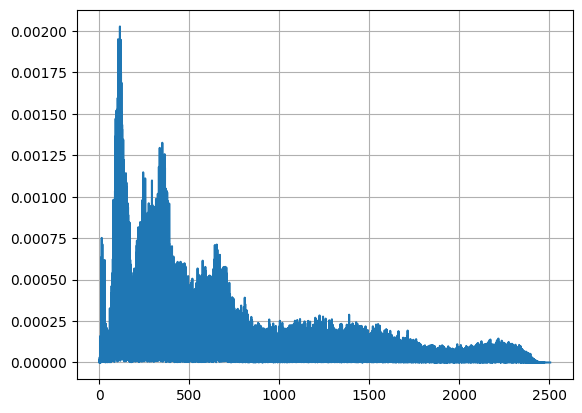

In [13]:
yf = fft(y)
N = len(yf)
yf_trunc = 2/N * np.abs(yf[:N//2])

# Sample spacing = 1 / Sample rate
xf = fftfreq(N, 1/sr)
xf_trunc = xf[:N//2]
plt.plot(xf_trunc, yf_trunc)
plt.grid()
plt.show()

In [14]:
xf_trunc

array([0.00000000e+00, 6.05419300e-03, 1.21083860e-02, ...,
       2.50598184e+03, 2.50598789e+03, 2.50599395e+03])

In [15]:
librosa.get_duration(y=y, sr=sr)

165.17478052673584

In [16]:
len(yf)

827856

In [17]:
N/sr

165.17478052673584

### Spectrogram

Spectrogram can be expressed as squared magnitude of [Short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform):

$$
\text{spectrogram}\{x(t)\}(\tau, \omega) \equiv |X(\tau, \omega)|^2\text{,}
$$

where $\tau$ is a point in time, $\omega$ is the frequency and $X$ is a Fourier Transform. The definition of descrete-time STFT
can be expressed as:

$$
\bold{STFT}\{x[n]\}(m, \omega) \equiv X(m, \omega) = \sum_{n=-\infty}^\infty x[n]w[n - m]e^{-i\omega n}\text{,}
$$

where $m$ is discrete equivalent of $\tau$ and $w$ is a [windowing function](https://en.wikipedia.org/wiki/Window_function).
According to wikipedia article, the most convenient choices of windowing function are Hann window or Gaussian window.

In [117]:
import numpy.lib.stride_tricks as stride_tricks

def stft(x: np.ndarray, frameSize, overlapFactor=0.5, window_type=np.hanning):
    """Short-time Fourier Transform"""

    window = window_type(frameSize)
    strideSize = int(frameSize - np.ceil(frameSize * overlapFactor))

    # Prepend and append zeros to signal, so that first and last x can be a middle value in a window
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), x)
    windowCount = int(np.ceil(len(samples)/strideSize))
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(windowCount, frameSize),
                                      strides=(samples.strides[0]*strideSize, samples.strides[0]))

    frames = frames * window

    return np.fft.rfft(frames)

In [274]:
filepath = os.path.join(DAPS_PATH, "sample", "m2_script1_clean.wav")

# Set sr to None to use native sample rate
y, sr = librosa.load(filepath, sr=5012)
yf = stft(y, 2048)

1.7763568394002505e-15


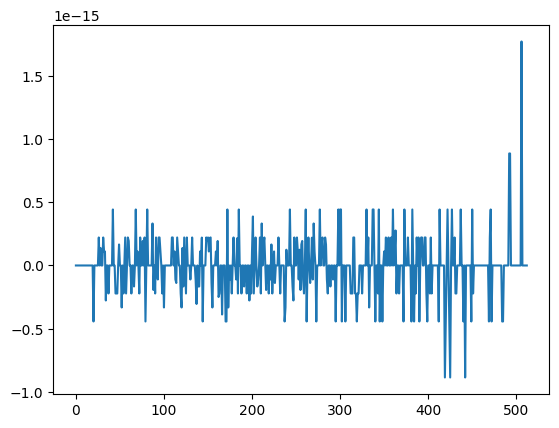

In [226]:
yf2 = np.log(np.real(yf)**2 + np.imag(yf)**2)
yf3 = np.log(np.abs(yf)**2)
# yf2 = yf2 - np.min(yf2)
print((yf2[0] - yf3[0]).max())
plt.plot(yf2[0] - yf3[0])

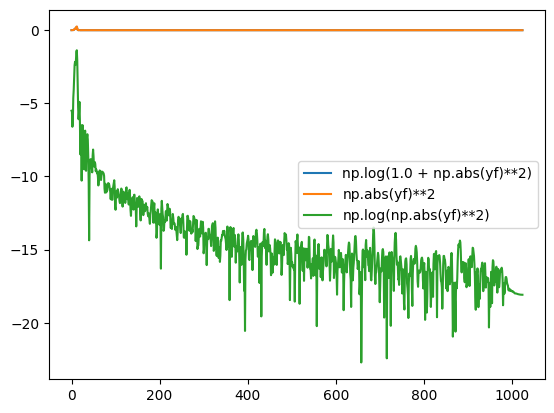

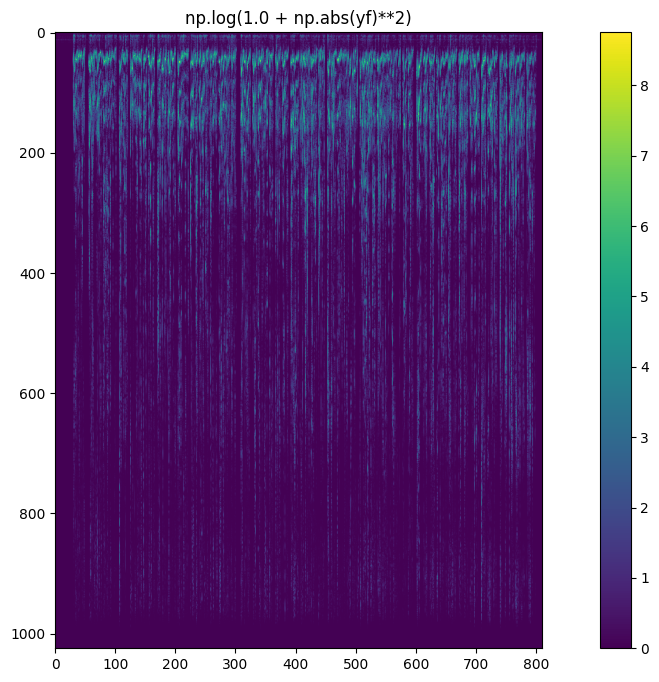

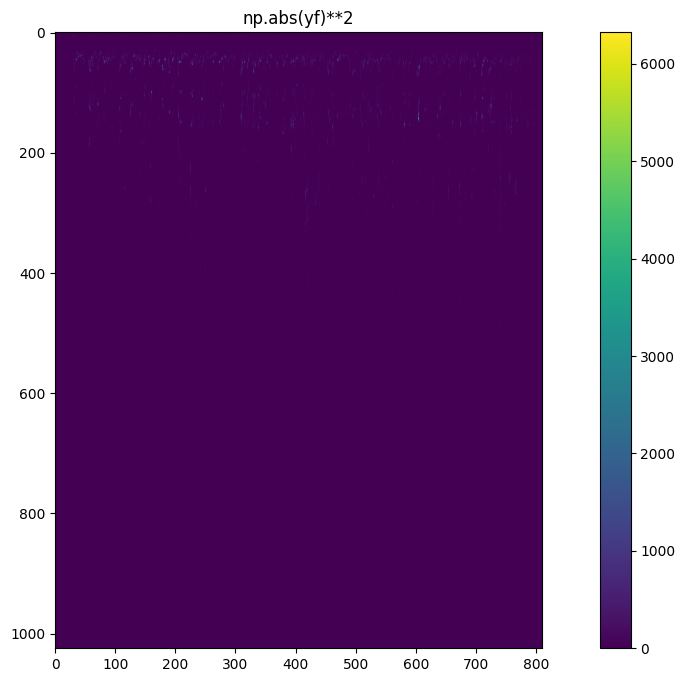

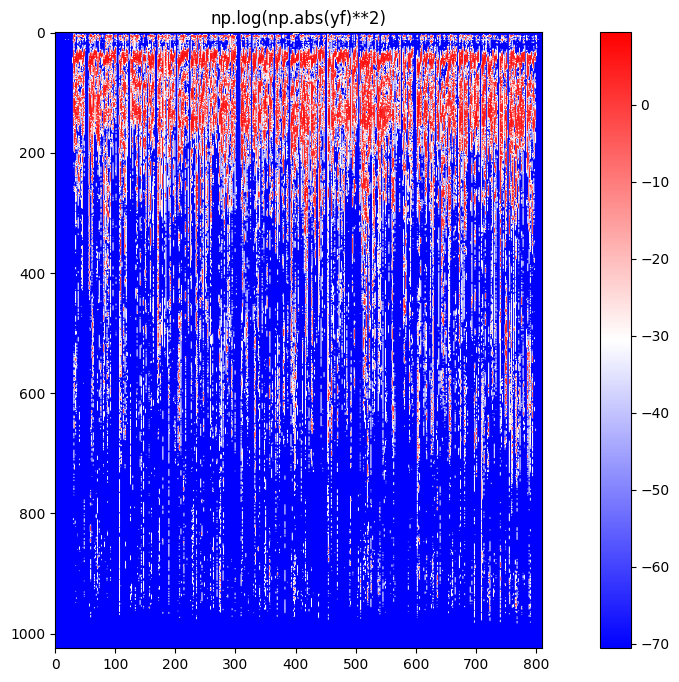

In [275]:
yf2 = np.log(1.0 + np.abs(yf)**2)
yf3 = np.abs(yf)**2
yf4 = np.log(np.abs(yf)**2)

plt.plot(yf2[0], label="np.log(1.0 + np.abs(yf)**2)")
plt.plot(yf3[0], label="np.abs(yf)**2")
plt.plot(yf4[0], label="np.log(np.abs(yf)**2)")
plt.legend()
plt.show()

plt.figure(figsize=(15, 8))
plt.title("np.log(1.0 + np.abs(yf)**2)")
plt.imshow(yf2.T)
plt.colorbar()

plt.figure(figsize=(15, 8))
plt.title("np.abs(yf)**2")
plt.imshow(yf3.T)
plt.colorbar()


plt.figure(figsize=(15, 8))
plt.title("np.log(np.abs(yf)**2)")
plt.imshow(librosa.power_to_db(yf4.T), cmap="bwr")
plt.colorbar()
# plt.colorbar()

(1618, 513)


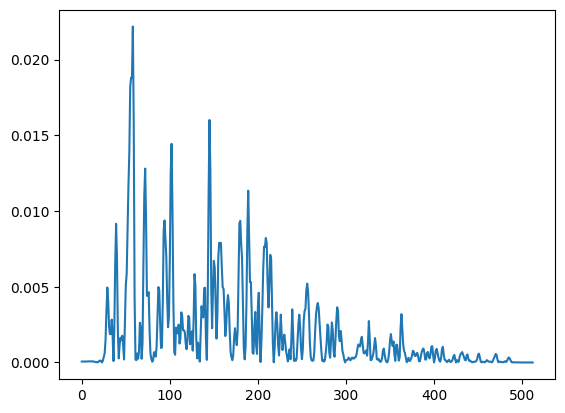

In [228]:
print(yf.shape)
plt.plot(2/len(yf[0]) * (np.abs(yf[0]))**2)
plt.show()

In [95]:
x = np.arange(10)
stride_tricks.as_strided(x, shape=(3, 4), strides=(x.strides[0]*1, x.strides[0]))

array([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5]])

In [102]:
x = np.arange(2, 12)
stft(x, frameSize=5, overlapFactor=0.0)

strideSize: 5
samples: [ 0.  0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
windowCount: 3
samples: [ 0.  0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.  0.  0.  0.  0.  0.]
frames:
 [[ 0.  0.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11.  0.  0.  0.]]
window:
 [0.  0.5 1.  0.5 0. ]
frames * window:
 [[0.  0.  2.  1.5 0. ]
 [0.  3.  7.  4.  0. ]
 [0.  5.5 0.  0.  0. ]]


In [62]:
stride_tricks.sliding_window_view(x, window_shape=(3, ))

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

Solution found at StackOverflow:

timebins:  14227
freqbins:  513


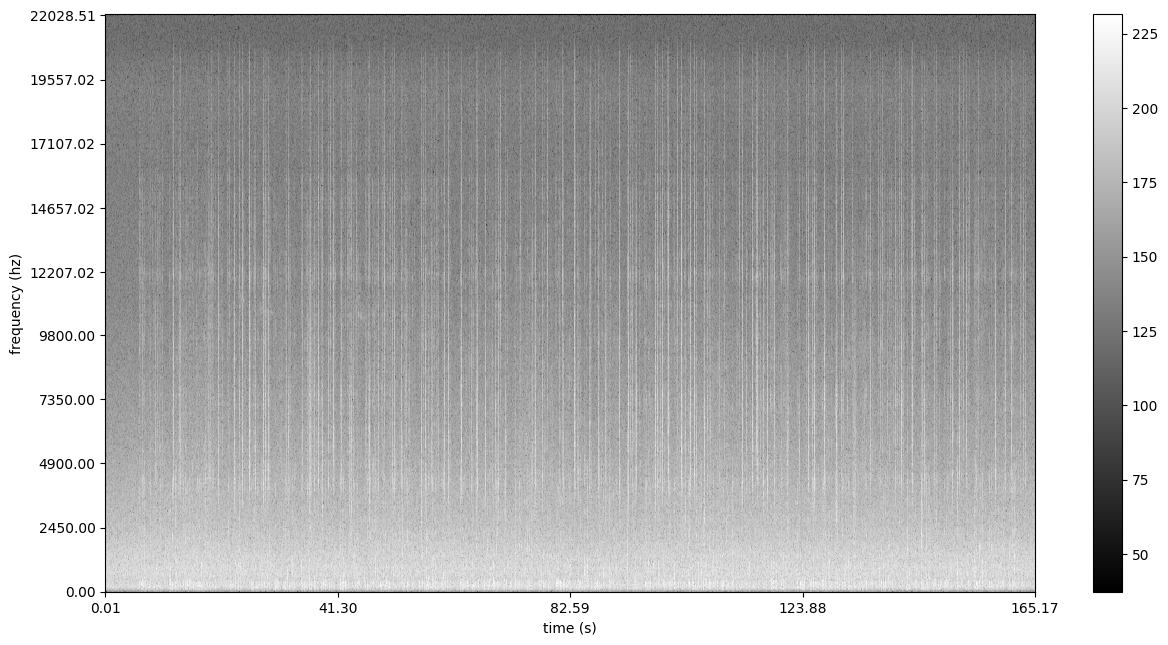

<Figure size 640x480 with 0 Axes>

In [239]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft2(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)

""" scale frequency axis logarithmically """
def logscale_spec2(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft2(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)

    s = stft2(samples, binsize)

    sshow, freq = logscale_spec2(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    print("timebins: ", timebins)
    print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

    plt.clf()

    return ims

ims = plotstft2(filepath, colormap="gray")

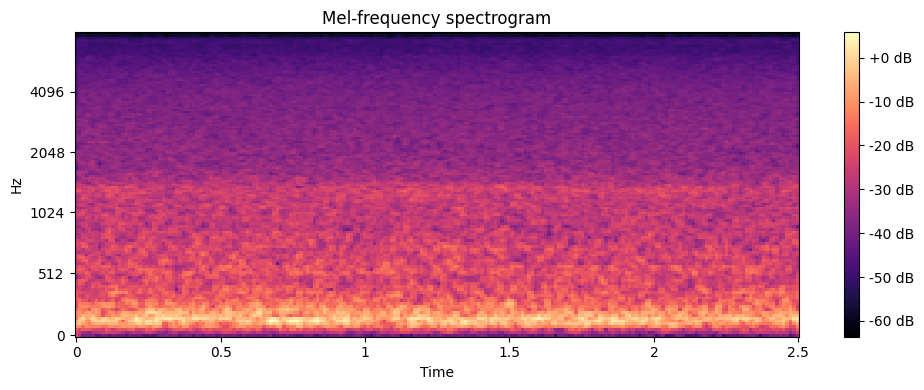

In [38]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()
plt.close()

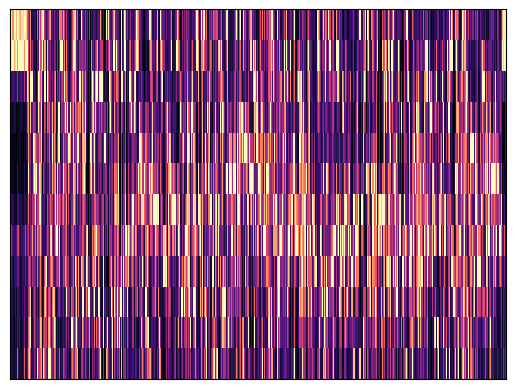

In [258]:
S = np.abs(librosa.stft(y, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
librosa.display.specshow(chroma, sr=sr)

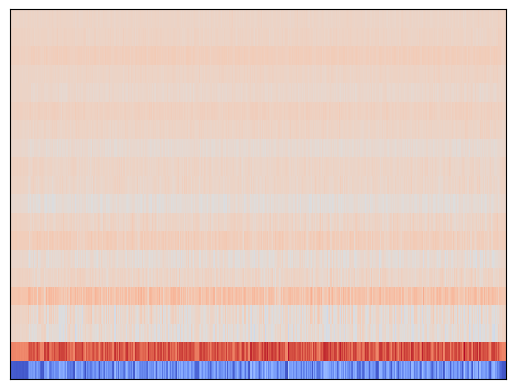

In [262]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
librosa.display.specshow(mfcc, sr=sr)

In [5]:
import librosa
import os

filepath = os.path.join(DAPS_PATH, "sample", "m2_script1_ipad_bedroom1.wav")
y, sr = librosa.load(filepath, sr=None, duration=7.0)
print("Duration:", librosa.get_duration(y=y, sr=sr))
print("Number of samples:", len(y))
print("Sample rate:", sr)

Duration: 7.0
Number of samples: 308700
Sample rate: 44100


In [8]:
split_points = np.arange(start=sr, stop=len(y), step=2*sr)
print(split_points)
# np.split(y, split_points)

[ 44100 132300 220500]


0.02682450000000003


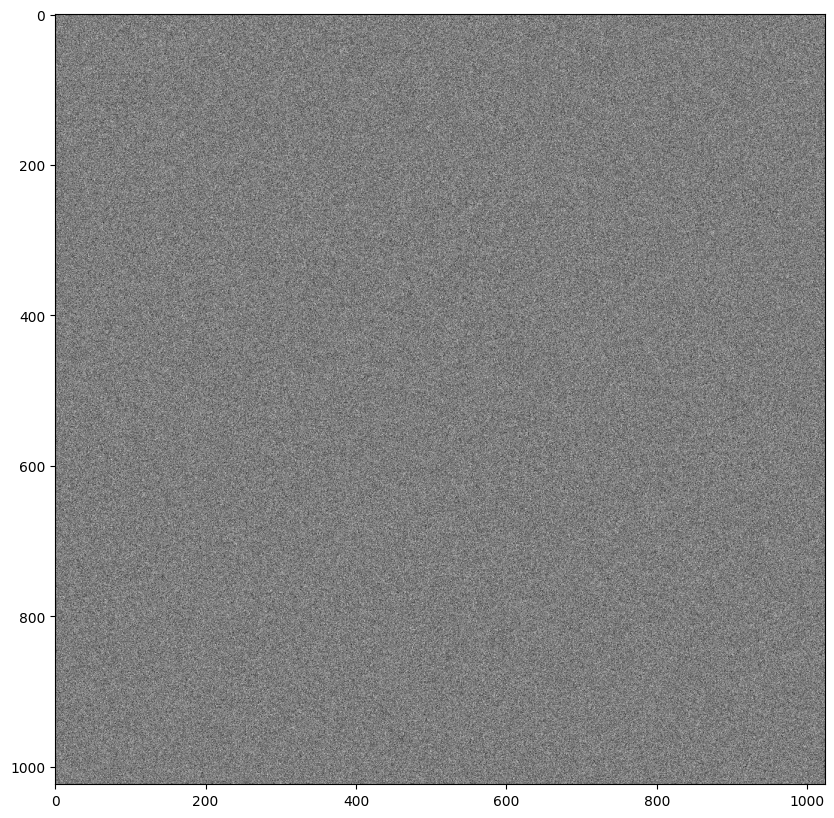

In [18]:
import time
start = time.process_time()
noise = np.random.normal(0, 1, (1024, 1024))
print(time.process_time() - start)
plt.figure(figsize=(10,10))
plt.imshow(noise, cmap="gray")

In [17]:
S = librosa.feature.melspectrogram(y=y, sr=sr,
                                   n_mels=256,
                               )
print(S.shape)
logS = librosa.power_to_db(S)
logS2 = librosa.power_to_db(S, ref=np.max(S))
logS3 = librosa.power_to_db(S, ref=np.min(S))
print(logS-logS2)
logS
print(logS.shape)
# fig, ax = plt.subplots(1, 1, figsize=(logS.shape[0], 100))
# print(type(ax))
# librosa.display.specshow(logS, sr=sr, fmax=sr/2.0, ax=ax)
# fig.savefig("dupa.png")
# plt.imshow(logS)
# fig.colorbar()
# plt.show()
vmin = np.min(logS2)
vmax = np.max(logS2)

plt.imsave("dupab.png", logS2, cmap="bwr", vmin=vmin, vmax=vmax)
plt.imsave("dupa2b.png", logS2[:, :256], cmap="bwr")
plt.imsave("dupa3b.png", logS2[:, :256], cmap="bwr", vmin=vmin, vmax=vmax)

(256, 431)
[[6.514639 6.514639 6.514637 ... 6.514637 6.514637 6.514637]
 [6.514637 6.514639 6.514637 ... 6.514637 6.514637 6.514637]
 [6.514639 6.514637 6.514637 ... 6.514637 6.514637 6.514637]
 ...
 [6.514637 6.514641 6.514641 ... 6.514637 6.514637 6.514637]
 [6.514637 6.514637 6.514641 ... 6.514641 6.514641 6.514637]
 [6.514641 6.514637 6.514641 ... 6.514637 6.514641 6.514637]]
(256, 431)


In [5]:
print(np.min(logS))
print(np.max(logS))
logS

-44.228924
35.771076


array([[-23.466684, -28.47555 , -37.717216, ..., -44.228924, -44.228924,
        -25.246408],
       [-22.922016, -28.650743, -39.385155, ..., -44.228924, -44.228924,
        -24.279457],
       [-21.19856 , -28.00412 , -44.228924, ..., -44.228924, -44.228924,
        -22.091583],
       ...,
       [-44.228924, -44.228924, -44.228924, ..., -44.228924, -44.228924,
        -44.228924],
       [-44.228924, -44.228924, -44.228924, ..., -44.228924, -44.228924,
        -44.228924],
       [-44.228924, -44.228924, -44.228924, ..., -44.228924, -44.228924,
        -44.228924]], dtype=float32)

In [6]:
print(np.min(logS2))
print(np.max(logS2))

-80.0
0.0


In [122]:
print(np.min(logS3))
print(np.max(logS3))

45.8022
125.8022


In [103]:
print("min: ", np.min(logS))
print("max: ", np.max(logS))

min:  -44.228924
max:  35.771076


In [67]:
print("S.shape:", S.shape)
print("logS.shape:", logS.shape)

S.shape: (256, 14227)
logS.shape: (256, 14227)


In [24]:
for i, val in enumerate(np.arange(0, 30, 3)):
    print(i, val)

0 0
1 3
2 6
3 9
4 12
5 15
6 18
7 21
8 24
9 27


In [26]:
x = [10 * i + np.arange(10) for i in range(10)]
np.min(x)

0

Shape: (256, 259, 4)


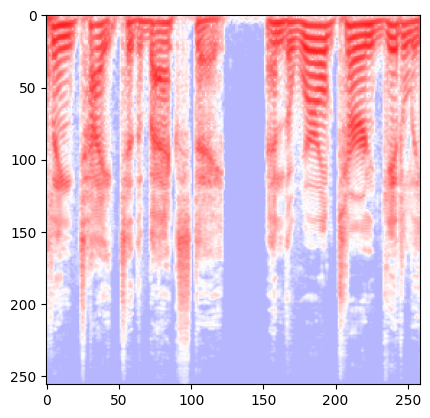

In [40]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import numpy as np

img = PIL.Image.open("../data/daps_img_overlap_034_256x3sec_1d/0/m2_script1_produced_38.png")
arr = np.array(img)
print("Shape:", arr.shape)
plt.imshow(arr)

Shape: (256, 259, 4)


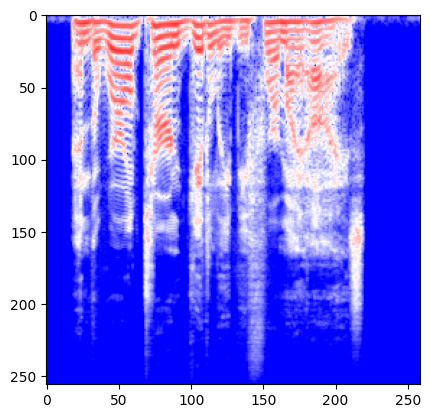

In [41]:
import PIL
import PIL.Image
import numpy as np

img = PIL.Image.open("../data/daps_img_overlap_034_256x259_2d/0/m2_script1_produced_38.png")
arr = np.array(img)
print("Shape:", arr.shape)
plt.imshow(arr)

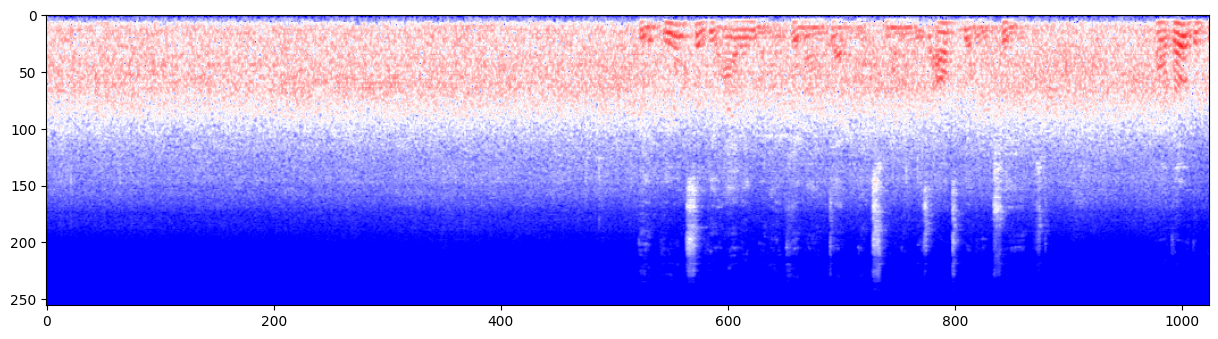

In [18]:
plt.figure(figsize=(15,15))
plt.imshow(arr[:, :1024, :])

[[255 236 236 255]
 [255 236 236 255]
 [255 232 232 255]
 ...
 [255 254 254 255]
 [255 248 248 255]
 [255 254 254 255]]


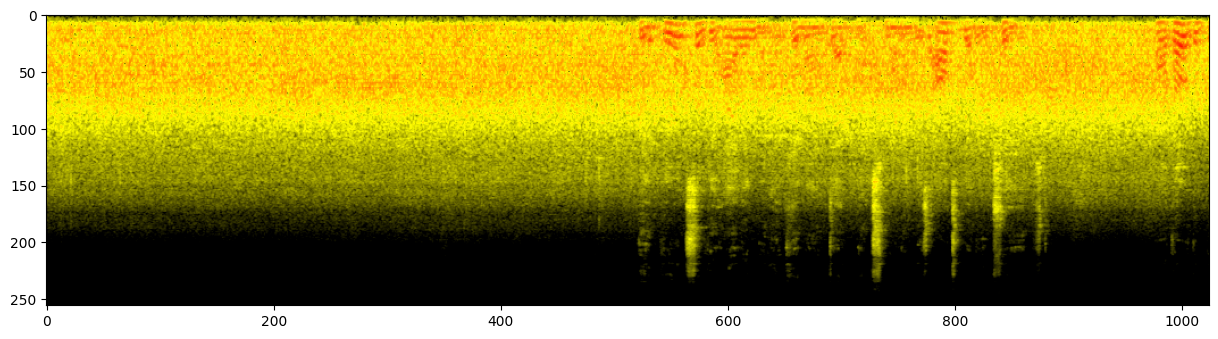

In [32]:
arr2 = arr.copy()
print(arr2[arr2[:, :, 2] != 255])
arr2[:, :, 2] = 0.0
plt.figure(figsize=(15,15))
plt.imshow(arr2[:, :1024, :])

In [59]:
arr3 = np.delete(arr, np.s_[::4], axis=2)
arr3 = arr[:,:,1:] - arr[:,:,:3]
print(arr3 != 0)
arr4 = np.sum(arr3 != 0, axis=1)
print(np.sum(arr4[:, 0]))
print(np.sum(arr4[:, 1]))
print(np.sum(arr4[:, 2]))
print(arr3.shape[0] * arr3.shape[1])

[[[False  True False]
  [False  True False]
  [False  True False]
  ...
  [False  True False]
  [False  True False]
  [False  True False]]

 [[False  True False]
  [False  True False]
  [False  True False]
  ...
  [False  True False]
  [False  True False]
  [False  True False]]

 [[False  True False]
  [False  True False]
  [False  True False]
  ...
  [False  True False]
  [False  True False]
  [False  True False]]

 ...

 [[False  True False]
  [False  True False]
  [False  True False]
  ...
  [False  True False]
  [False  True False]
  [False  True False]]

 [[False  True False]
  [False  True False]
  [False  True False]
  ...
  [False  True False]
  [False  True False]
  [False  True False]]

 [[False  True False]
  [False  True False]
  [False  True False]
  ...
  [False  True False]
  [False  True False]
  [False  True False]]]
1064322
2577790
1064322
3642112


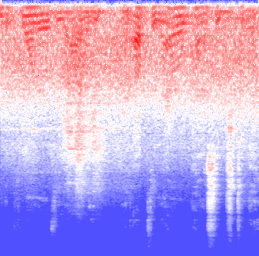

In [3]:
img

In [1]:
import numpy as np
import numpy.lib.stride_tricks as stride_tricks

def overlapping_frames(x: np.ndarray, frame_size: int, overlap_factor: float) -> np.ndarray:
    assert len(x) >= frame_size, f"Frame size ({frame_size}) exceeds length of x ({len(x)})."
    assert overlap_factor >= 0.0 and overlap_factor < 1.0,\
        f"Overlap factor ({overlap_factor}) has to be from range [0.0, 1.0)."

    stride_size = int(frame_size - np.floor(frame_size * overlap_factor))
    print(f"[LOG] \tStride size: {stride_size}")

    n = x.shape[0]
    print(f"[LOG] \tSamples shape: {x.shape}")
    print(f"[LOG] \tSamples len: {n}")
    window_count = int(np.floor((n - frame_size)/stride_size)) + 1
    print(f"[LOG] \tWindow count: {window_count}")

    stride_len = x.strides[0]
    frames = stride_tricks.as_strided(x, shape=(window_count, frame_size),
                                      strides=(stride_len*stride_size, stride_len))

    return frames

def overlapping_frames2D(X: np.ndarray, frame_size: int, overlap_factor: float) -> np.ndarray:
    assert len(X.shape) == 2, "X is not a 2D matrix."
    height, width = X.shape
    assert width >= frame_size, f"Frame size ({frame_size}) exceeds length of x ({len(x)})."

    assert overlap_factor >= 0.0 and overlap_factor < 1.0,\
        f"Overlap factor ({overlap_factor}) has to be from range [0.0, 1.0)."

    stride_size = int(frame_size - np.floor(frame_size * overlap_factor))
    print(f"[LOG] \tStride size: {stride_size}")

    print(f"[LOG] \tSamples shape: {X.shape}")
    print(f"[LOG] \tSamples len: {width}")

    # Remove offset from the beginning of the data, its just background noise
    offset = (width - frame_size) % stride_size
    X = X[:, offset:]
    height, width = X.shape
    window_count = (width - frame_size) // stride_size + 1
    print(f"[LOG] \tWindow count: {window_count}")

    print(f"[LOG] \tNew samples shape: {X.shape}")
    print(f"[LOG] \tNew samples len: {width}")

    stride_height, stride_width = X.strides
    frames = stride_tricks.as_strided(X, shape=(window_count, height, frame_size),
                                      strides=(stride_width*stride_size, stride_height, stride_width))

    return frames

In [2]:
len((1, 2))

2

In [123]:
x = np.arange(5)
overlapping_frames(x, 3, 0.3333333333333333)

[LOG] 	Stride size: 2
[LOG] 	Samples shape: (5,)
[LOG] 	Samples len: 5
[LOG] 	Window count: 2


array([[0, 1, 2],
       [2, 3, 4]])

In [122]:
1 / 3

0.3333333333333333

In [ ]:
import os
for entry in os.scandir("data/daps"):

    print(entry.name)

.DS_Store
iphone_bedroom1
LICENSE
ipad_confroom2
ipadflat_office1
ipadflat_confroom1
DAPS_README.txt
sample
ipad_balcony1
clean
produced
cleanraw
ipad_bedroom1
ipad_livingroom1
ipad_confroom1
ipad_office1
supplementary_files
ipad_office2
iphone_balcony1
iphone_livingroom1


In [18]:
filepath = os.path.join(DAPS_PATH, "sample", "m2_script1_ipad_bedroom1.wav")
y, sr = librosa.load(filepath, sr=None)
frames = overlapping_frames(y, 3 * sr, 0.33)
frames.shape

[LOG] 	Stride size: 88641
[LOG] 	Samples shape: (7284207,)
[LOG] 	Samples len: 7284207
[LOG] 	Window count: 81


(81, 132300)

y1: 7539712
y2: 7539712


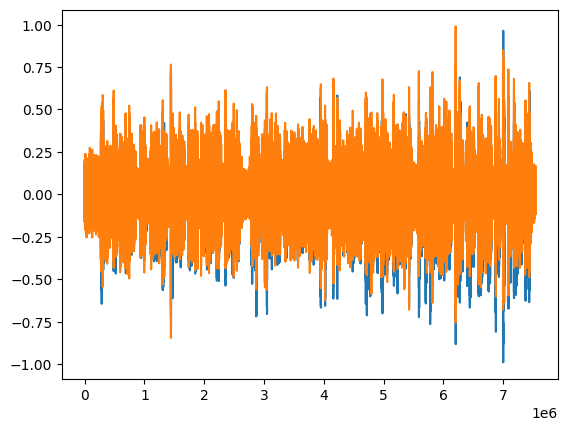

In [11]:
y1, sr1 = librosa.load(DAPS_PATH+"/clean/f1_script1_clean.wav", sr=None)
y2, sr2 = librosa.load(DAPS_PATH+"/ipad_balcony1/f1_script1_ipad_balcony1.wav", sr=None)
assert sr1 == sr2
assert len(y1) == len(y2)

print("y1:", len(y1))
print("y2:", len(y2))

plt.plot(np.arange(len(y1)), y1, y2)

In [14]:
def create_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    logS = librosa.power_to_db(S)
    return logS

logS1 = create_spectrogram(y1, sr1)
logS2 = create_spectrogram(y2, sr2)
assert logS1.shape == logS2.shape

In [15]:
logS1.shape

(128, 14727)

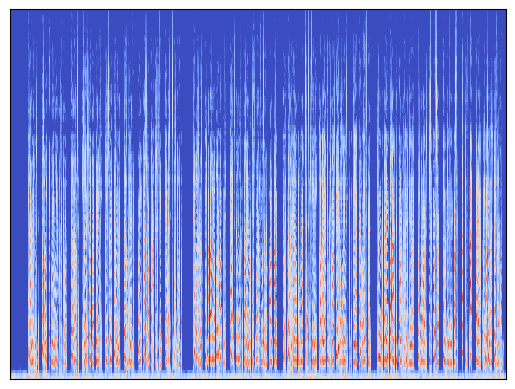

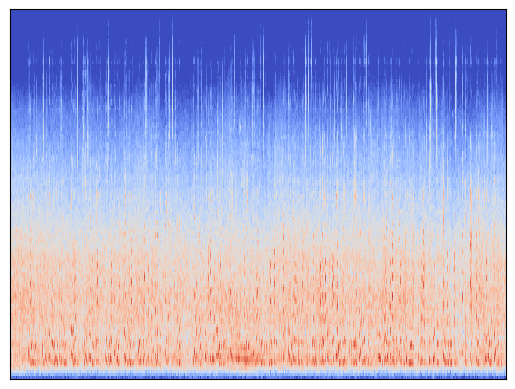

In [17]:
librosa.display.specshow(logS1)
plt.show()
librosa.display.specshow(logS2)
plt.show()

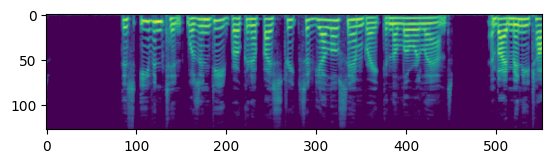

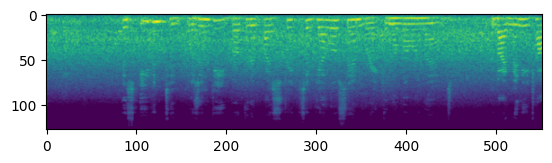

In [19]:
plt.imshow(logS1[:, 2048:2600])
plt.show()
plt.imshow(logS2[:, 2048:2600])
plt.show()

In [42]:
Frames1 = overlapping_frames2D(logS1, 256, 0.33)
Frames2 = overlapping_frames2D(logS2, 256, 0.33)

assert Frames1.shape == Frames2.shape

[LOG] 	Stride size: 172
[LOG] 	Samples shape: (128, 14727)
[LOG] 	Samples len: 14727
[LOG] 	Window count: 85
[LOG] 	New samples shape: (128, 14620)
[LOG] 	New samples len: 14620
[LOG] 	Stride size: 172
[LOG] 	Samples shape: (128, 14727)
[LOG] 	Samples len: 14727
[LOG] 	Window count: 85
[LOG] 	New samples shape: (128, 14620)
[LOG] 	New samples len: 14620


In [43]:
57*256

14592

In [45]:
Frames1

array([[[-1.76142178e+01, -2.33030548e+01, -2.59386272e+01, ...,
         -1.09752197e+01, -1.17592087e+01, -1.10501499e+01],
        [-2.15337029e+01, -2.87755203e+01, -3.26138916e+01, ...,
         -1.46558113e+01, -1.46401367e+01, -1.55340872e+01],
        [-3.78492432e+01, -4.34638367e+01, -4.57022285e+01, ...,
         -3.09260483e+01, -3.15432625e+01, -3.29417267e+01],
        ...,
        [-4.93583221e+01, -4.93583221e+01, -4.93583221e+01, ...,
         -4.93583221e+01, -4.93583221e+01, -4.93583221e+01],
        [-4.93583221e+01, -4.93583221e+01, -4.93583221e+01, ...,
         -4.93583221e+01, -4.93583221e+01, -4.93583221e+01],
        [-4.93583221e+01, -4.93583221e+01, -4.93583221e+01, ...,
         -4.93583221e+01, -4.93583221e+01, -4.93583221e+01]],

       [[-9.52134323e+00, -1.15789080e+01, -1.45459661e+01, ...,
         -1.46084604e+01, -8.75108910e+00, -5.55524874e+00],
        [-1.33621302e+01, -1.54868889e+01, -1.86761112e+01, ...,
         -2.22089939e+01, -1.57433662e

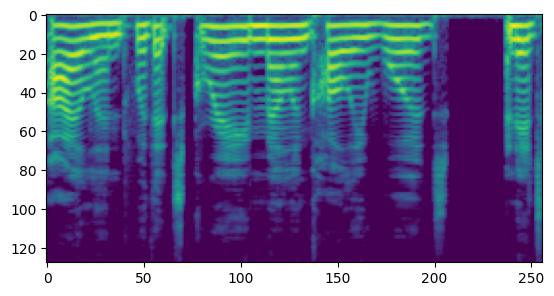

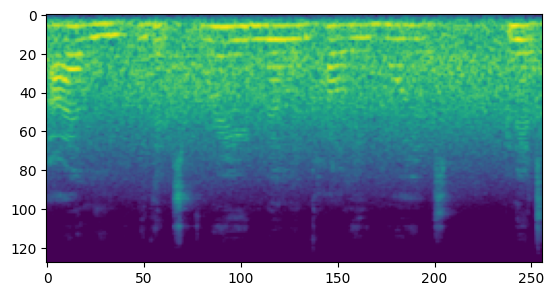

In [41]:
plt.imshow(Frames1[32])
plt.show()
plt.imshow(Frames2[32])
plt.show()

In [3]:
X = np.arange(12).reshape(2, 6)
X

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

In [27]:
Y = overlapping_frames2D(X, 5, 0.8)

[LOG] 	Stride size: 1
[LOG] 	Samples shape: (2, 6)
[LOG] 	Samples len: 6
[LOG] 	Window count: 2
[LOG] 	New samples shape: (2, 6)
[LOG] 	New samples len: 6


In [28]:
Y

array([[[ 0,  1,  2,  3,  4],
        [ 6,  7,  8,  9, 10]],

       [[ 1,  2,  3,  4,  5],
        [ 7,  8,  9, 10, 11]]])